In [12]:
from typing import Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

## SARIMAXモデルを調べる

In [2]:
df_macro = sm.datasets.macrodata.load_pandas().data
df_macro.index = pd.PeriodIndex(
    df_macro.apply(lambda ser: f"{int(ser['year'])}Q{int(ser['quarter'])}", axis=1),
    freq='Q', name='date'
)
df_macro.drop(columns=['year', 'quarter'], inplace=True)
df_macro.head(10)

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
date,,,,,,,,,,,,
1959Q1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959Q2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959Q3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959Q4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960Q1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19
1960Q2,2834.390,1792.9,298.152,460.400,1966.1,29.55,140.2,2.68,5.2,180.671,0.14,2.55
1960Q3,2839.022,1785.8,296.375,474.676,1967.8,29.75,140.9,2.36,5.6,181.528,2.70,-0.34
1960Q4,2802.616,1788.2,259.764,476.434,1966.6,29.84,141.1,2.29,6.3,182.287,1.21,1.08
1961Q1,2819.264,1787.7,266.405,475.854,1984.5,29.81,142.1,2.37,6.8,182.992,-0.40,2.77


| 変数 | 説明 |
| ---- | ---- |
| realgdp | 実質国内総生産(目的変数または内生変数) |
| realcons | 実質個人消費支出 |
| realinv | 実質民間国内総投資額 |
| realgovt | 連邦政府の実質消費支出および投資額 |
| realdpi | 実質個人可処分所得 |
| cpi | 四半期末消費者物価指数 |
| m1 | M1名目貨幣供給量 |
| tbilrate | 3ヶ月物短期国債の四半期月次平均 |
| unemp | 季節調整失業率 |
| pop | 四半期末人口 |
| infl | インフレ率 |
| realint | 実質金利率 |

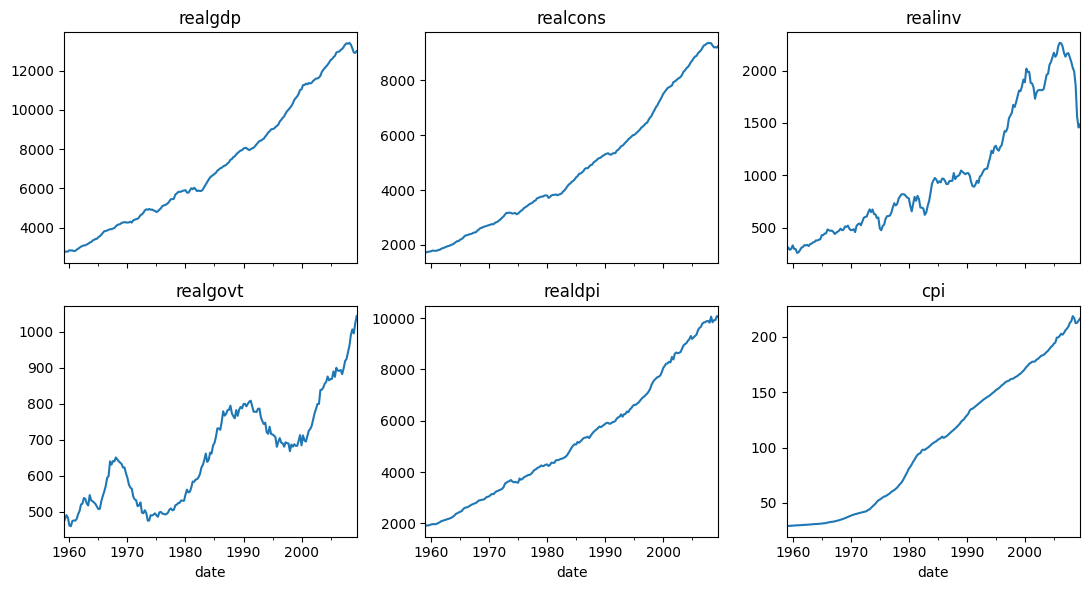

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(11, 6), sharex=True)
axes = axes.flatten()
for i in range(6):
    df_macro.iloc[:, i].plot(ax=axes[i])
    axes[i].set_title(df_macro.columns[i])
fig.tight_layout()

## SARIMAXモデルを使って実質GDPを予測する

In [29]:
# 目的変数、外生変数を定義
# シンプルのため外生変数は5つに制限
target = df_macro[['realgdp']]
exog = df_macro.iloc[:, 1:6]

# train, testにわける
target_train = target[:200]
exog_train = exog[:200]

In [31]:
# 定常性の確認
for d in [0, 1]:
    ADF_result = adfuller(np.diff(target['realgdp'], n=d))
    print(f'実質GDP({d}次差分)ADF検定')
    print(f'ADF Statistic: {ADF_result[0]:.3f}')
    print(f'p-value: {ADF_result[1]:.3f}')

実質GDP(0次差分)ADF検定
ADF Statistic: 1.750
p-value: 0.998
実質GDP(1次差分)ADF検定
ADF Statistic: -6.306
p-value: 0.000


In [32]:
# 一意なSARIMAXモデルをすべて適合させる関数
def optimize_SARIMAX(
    endog: Union[pd.Series, list], 
    exog: Union[pd.Series, list],
    orders: list, 
    d: int,
    D: int,
    s: int
) -> pd.DataFrame:
    """
    endog: 時系列データ
    exog: 外生変数
    orders: SARIMAX(p, d, q)のpとqの値の組み合わせ
    d: 和分次数
    D: 季節差分の次数
    s: 頻度
    """
    res = []
    for order in tqdm(orders):
        try:
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False
            ).fit(disp=False)
            res.append([order, model.aic])
        except:
            continue
    df_res = (
        pd.DataFrame(res, columns=['(p,q,P,Q)', 'AIC'])
        .sort_values(by='AIC', ascending=True)
        .reset_index(drop=True)
    )
    return df_res

In [33]:
d = 1
D = 0
s = 4
orders = list(product(range(4), repeat=4)) # p,q,P,Qをそれぞれ0~4まで動かす
optimize_SARIMAX(target_train, exog_train, orders, d, D, s)

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(0, 1, 2, 3)",266.143045
1,"(3, 2, 3, 0)",2145.460369
2,"(3, 3, 1, 1)",2145.820653
3,"(3, 3, 0, 1)",2145.979871
4,"(3, 1, 3, 0)",2146.012430
...,...,...
247,"(0, 0, 0, 2)",2234.293056
248,"(0, 0, 0, 3)",2235.079581
249,"(0, 1, 0, 0)",2242.318380
250,"(0, 0, 0, 1)",2250.954180


In [34]:
# (p,q,P,Q)=(0,1,2,3)がなぜか一番小さい
# オーダーも小さすぎる気がするので無視する
model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False).fit(disp=False)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.412
Date:                Fri, 17 Nov 2023   AIC                           1742.824
Time:                        20:11:00   BIC                           1782.344
Sample:                    03-31-1959   HQIC                          1758.819
                         - 12-31-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9708      0.045     21.505      0.000       0.882       1.059
realinv        1.0132      0.033     30.693      0.000       0.948       1.078
realgovt       0.7283      0.127      5.728      0.0

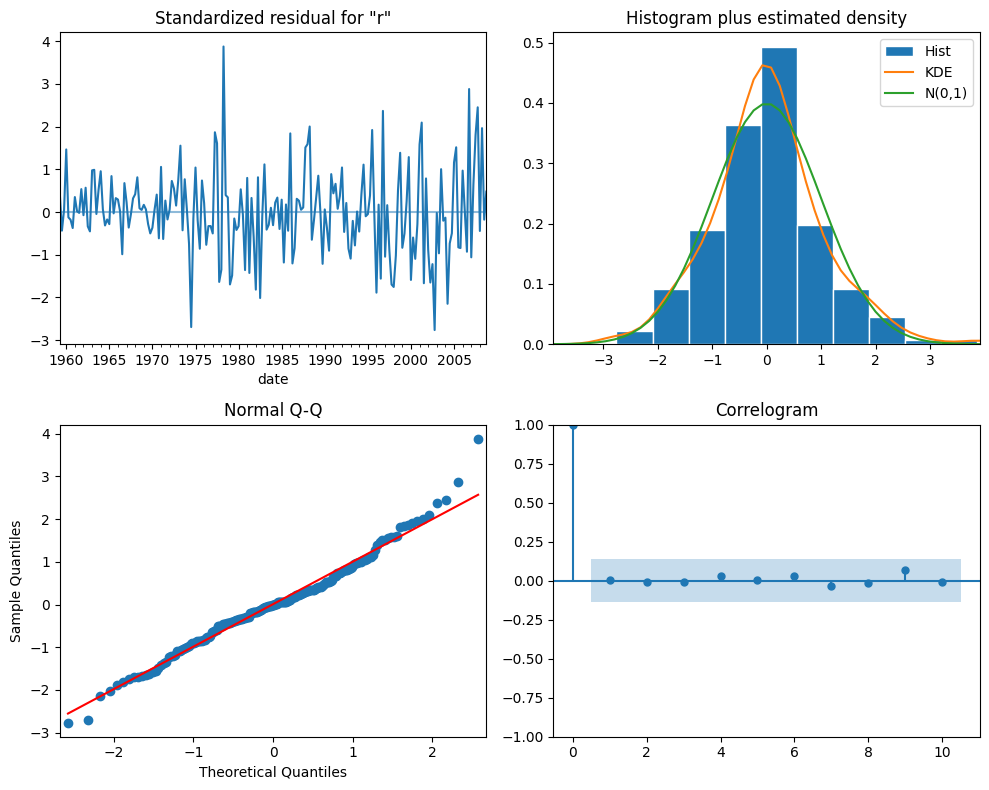

In [35]:
model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()

In [36]:
# 残差が無相関であることが確認できる
acorr_ljungbox(model.resid, np.arange(1, 11))

,lb_stat,lb_pvalue
1,0.092071,0.761560
2,0.198871,0.905348
3,0.200938,0.977438
4,1.257216,0.868591
5,1.258003,0.939193
6,1.285134,0.972471
7,1.476883,0.983099
8,1.486838,0.992924
9,1.859312,0.993502
10,1.866005,0.997268


In [81]:
def rolling_forecast(
    endog: Union[pd.Series, list],
    exog: Union[pd.Series, list],
    train_len: int,
    horizon: int,
    window: int,
    method: str
) -> list:
    
    total_len = train_len + horizon
    preds = []
    
    if method == 'last':
        for i in range(train_len, total_len, window):
            val_last = endog.iloc[i-1, 0]
            preds.extend(val_last for _ in range(window))
    elif method == 'SARIMAX':
        for i in range(train_len, total_len, window):
            model = SARIMAX(
                endog[:i],
                exog[:i],
                order=(3,1,3),
                seasonal_order=(0,0,0,4),
                simple_differencing=False
            ).fit(disp=False)
            pred = model.forecast(window, exog=exog[i:i+window]).values
            preds.extend(pred)
    else:
        raise ValueError('choose method form [last, SARIMAX]')
    return preds

In [82]:
target_train = target[:196]
target_test = target[196:]

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

target_test['pred_last'] = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
target_test['pred_SARIMAX'] = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

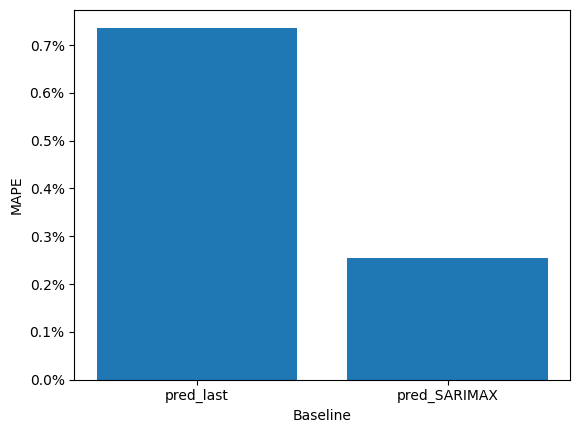

In [86]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))

xs = ['pred_last', 'pred_SARIMAX']
ys = [mape(target_test['realgdp'], target_test[x]) for x in xs]

plt.bar(xs, ys)
plt.xlabel('Baseline')
plt.ylabel('MAPE')
# set y value to percentage
plt.gca().yaxis.set_major_formatter(lambda y, _: '{:.01%}'.format(y))